# Block Model using `emg3d`

In [1]:
import emg3d
import discretize
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Load model and survey

In [3]:
survey = xr.load_dataset('../block_model_and_survey.nc', engine='h5netcdf')
survey

<xarray.Dataset>
Dimensions:    (x: 101)
Coordinates:
  * x          (x) float64 -1e+04 -9.8e+03 -9.6e+03 ... 9.6e+03 9.8e+03 1e+04
Data variables:
    line_1_im  (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    line_1_re  (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    line_2_im  (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    line_2_re  (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    line_3_im  (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    line_3_re  (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Attributes:
    aniso:      [1.         1.         1.         1.41421356 1.        ]
    cputime:    N/A
    date:       2020-03-18T07:24:41.694234
    depth:      [    0.  -600.  -850. -3150.]
    freq:       1.0
    hx:         [5500. 4000.  500.  500. 4000. 5500.]
    hy:         [6000. 1000. 3000. 3000. 1000. 6000.]
    hz:         [ 250.   50. 1250.  250.  750.  250.  600.  500.]
    machine:    N/A
    maxram:     N/A
    ncell:      N/A
    nedges:     N/A
    nthreads:   N/A
    rec_dip:    0.0
    rec_theta:  0.0
    rec_y:      [-3000.     0.  3000.]
    rec_z:      -600.0
    res1d:      [1.e+08 3.e-01 1.e+00 2.e+00 1.e+03]
    resh_bg:    [[[1.e+03 2.e+00 2.e+00 2.e+00 2.e+00 1.e+00 3.e-01 1.e+08]\n...
    resh_tg:    [[[1.e+03 2.e+00 2.e+00 2.e+00 2.e+00 1.e+00 3.e-01 1.e+08]\n...
    resv_bg:    [[[1.e+03 4.e+00 4.e+00 4.e+00 4.e+00 1.e+00 3.e-01 1.e+08]\n...
    resv_tg:    [[[1.e+03 4.e+00 4.e+00 4.e+00 4.e+00 1.e+00 3.e-01 1.e+08]\n...
    runtime:    N/A
    src:        [-100.  100.    0.    0. -550. -550.]
    strength:   800.0
    version:    N/A
    x0:         [-10000. -10000.  -3400.]

### Extract required info

In [4]:
# Mesh
hx, hy, hz = survey.attrs['hx'], survey.attrs['hy'], survey.attrs['hz']
x0 = survey.attrs['x0']
mesh_model = discretize.TensorMesh([hx, hy, hz], x0=x0)

# Models
resh_bg, resv_bg = survey.attrs['resh_bg'], survey.attrs['resv_bg']
resh_tg, resv_tg = survey.attrs['resh_tg'], survey.attrs['resv_tg']

# Survey
src = survey.attrs['src']
strength = survey.attrs['strength']
freq = survey.attrs['freq']
rec_x = survey.x.data
rec_y = survey.attrs['rec_y']
rec_z = survey.attrs['rec_z']

# Calculate source center (for meshing)
src_c = np.mean(src.reshape(-1, 2), 1)

## `emg3d` computation

For the background model, we could get away with a much coarser mesh. However, for simplicity we just use the same mesh for the background model and the full model.

Also, for the 1D model we only calculate the receiver lines for y=0 and y=-3 km, as the result for y=+/-3 km are identical.

In [5]:
min_width = 100  # Testing, change to 50?

# Get cell widths and origin in each direction
xx, x0 = emg3d.utils.get_hx_h0(
    freq=freq, res=[0.3, 1000], fixed=src_c[0], domain=[-4500, 4500], min_width=100)
yy, y0 = emg3d.utils.get_hx_h0(
    freq=freq, res=[0.3, 1000], fixed=src_c[1], domain=[-4000, 4000], min_width=100)
zz, z0 = emg3d.utils.get_hx_h0(
    freq=freq, res=[0.3, 100, 1000], fixed=rec_z, domain=[-3200, 0], min_width=100)

   Skin depth (m/l-r)  [m] : 276 / 15916
   Survey domain       [m] : -4500 - 4500
   Calculation domain  [m] : -100000 - 100000
   Final extent        [m] : -106581 - 106581
   Min/max cell width  [m] : 100 / 100 / 26001
   Alpha survey/calc       : 1.000 / 1.340
   Number of cells (s/c/r) : 128 (90/38/0)

   Skin depth (m/l-r)  [m] : 276 / 15916
   Survey domain       [m] : -4000 - 4000
   Calculation domain  [m] : -100000 - 100000
   Final extent        [m] : -109379 - 109379
   Min/max cell width  [m] : 100 / 100 / 21176
   Alpha survey/calc       : 1.000 / 1.250
   Number of cells (s/c/r) : 128 (80/48/0)

   Skin depth (m/l/r)  [m] : 276 / 5033 / 15916
   Survey domain       [m] : -3200 - 0
   Calculation domain  [m] : -33523 - 99400
   Final extent        [m] : -35828 - 119289
   Min/max cell width  [m] : 100 / 100 / 32948
   Alpha survey/calc       : 1.000 / 1.380
   Number of cells (s/c/r) : 64 (32/32/0)



In [6]:
# Create a TensorMesh instance.
mesh_3d = discretize.TensorMesh([xx, yy, zz], x0=[x0, y0, z0])
mesh_3d

TensorMesh: 1,048,576 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128   -106,580.68    106,580.68    100.00 26,001.07    1.34
   y    128   -109,379.12    109,379.12    100.00 21,175.82    1.25
   z     64    -35,828.39    119,288.59    100.00 32,947.58    1.38

In [7]:
# Interpolate to new mesh
cresh_3d_tg = emg3d.utils.grid2grid(mesh_model, resh_tg, mesh_3d, 'volume', log=True)
cresv_3d_tg = emg3d.utils.grid2grid(mesh_model, resv_tg, mesh_3d, 'volume', log=True)
cresh_3d_bg = emg3d.utils.grid2grid(mesh_model, resh_bg, mesh_3d, 'volume', log=True)
cresv_3d_bg = emg3d.utils.grid2grid(mesh_model, resv_bg, mesh_3d, 'volume', log=True)

# Create model
model_3d_tg = emg3d.utils.Model(mesh_3d, res_x=cresh_3d_tg, res_z=cresv_3d_tg)
model_3d_bg = emg3d.utils.Model(mesh_3d, res_x=cresh_3d_bg, res_z=cresv_3d_bg)

# QC background model
#mesh_3d.plot_3d_slicer(
#    np.log10(model_3d_bg.res_x), #zslice=-2000,
#    xlim=(-10000, 10000),
#    ylim=(-10000, 10000),
#    zlim=(-6000, 500),
#    clim=np.log10([0.2, 200])
#)

### 2. Background calculation

For the background, we only calculate the receiver lines for y=0 and y=-3 km, as the result for y=+/-3 km are identical.

In [8]:
# Source field
sfield_3d = emg3d.utils.get_source_field(mesh_3d, src, freq, strength=strength)

efield_3d_bg = emg3d.solve(
    mesh_3d, model_3d_bg, sfield_3d,
    sslsolver=True,
    semicoarsening=True,
    linerelaxation=True,
    verb=3
)


:: emg3d START :: 07:27:12 :: v0.9.4.dev4+ga8d8de2

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x  64     => 1,048,576 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   5   

   [hh:mm:ss]  rel. error            solver              MG          l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [07:27:32]   2.710e-03  after                       1 F-cycles    4 1
   [07:27:51]   1.814e-04  after                       2 F-cycles    5 2
   [07:28:09] 

In [9]:
# Extract (interpolate) Ex-field at receiver locations from the emg3d result.
egd_bg = np.zeros((rec_x.size, 2), dtype=complex)
for i, y in enumerate(rec_y[:2]):
    egd_bg[:, i] = emg3d.utils.get_receiver(mesh_3d, efield_3d_bg.fx, (rec_x, y, rec_z))

In [10]:
# Load empymod for comparison
epm_1d = xr.load_dataset('../results/layered_empymod.nc', engine='h5netcdf')

<IPython.core.display.Javascript object>


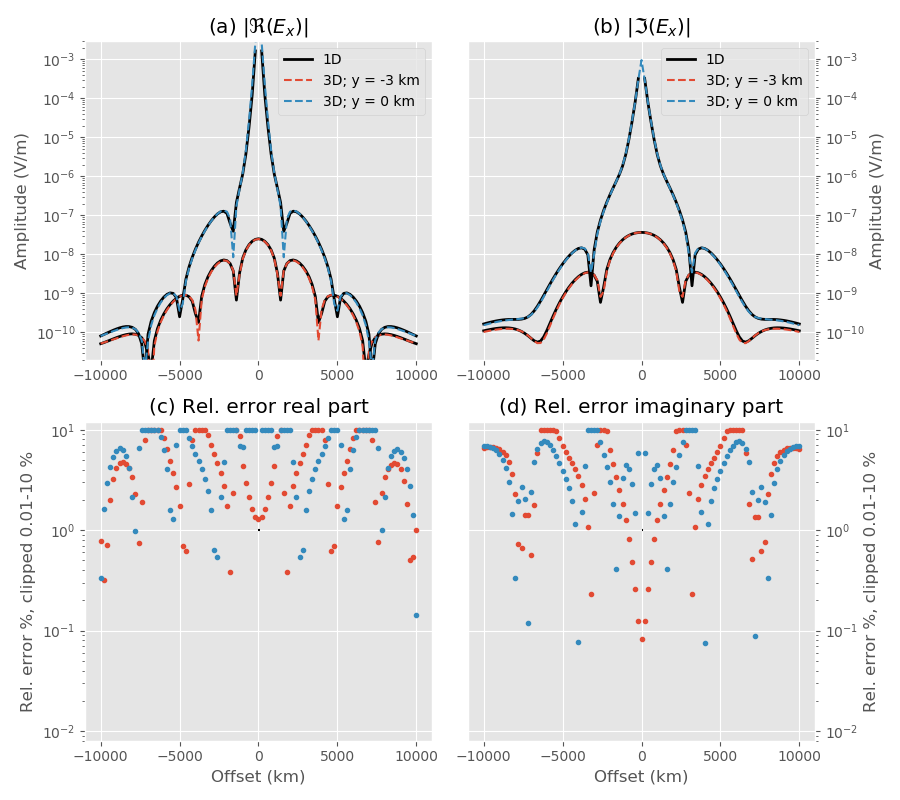

In [12]:
plt.figure(figsize=(9, 8))

# Real
ax1 = plt.subplot(221)
plt.title(r'(a) $|\Re(E_x)|$')
plt.plot(rec_x, abs(epm_1d.line_1_re), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].real), f'C0--', label=f'3D; y = {rec_y[0]/1e3:.0f} km')
plt.plot(rec_x, abs(epm_1d.line_2_re), f'k-', lw=2)
plt.plot(rec_x, abs(egd_bg[:, 1].real), f'C1--', label=f'3D; y = {rec_y[1]/1e3:.0f} km')
    
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(222, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

plt.plot(rec_x, abs(epm_1d.line_1_im), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].imag), f'C0--', label=f'3D; y = {rec_y[0]/1e3:.0f} km')
plt.plot(rec_x, abs(epm_1d.line_2_im), f'k-', lw=2)
plt.plot(rec_x, abs(egd_bg[:, 1].imag), f'C1--', label=f'3D; y = {rec_y[1]/1e3:.0f} km')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

# Real
ax3 = plt.subplot(223)
plt.title('(c) Rel. error real part')

# Calculate error
err_1 = np.clip(100*abs((epm_1d.line_1_re-egd_bg[:, 0].real)/epm_1d.line_1_re), 0.01, 10)
err_2 = np.clip(100*abs((epm_1d.line_2_re-egd_bg[:, 1].real)/epm_1d.line_2_re), 0.01, 10)

plt.plot(rec_x, err_1, 'C0.')
plt.plot(rec_x, err_2, 'C1.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-10 %')
plt.ylim([0.008, 12])

# Imaginary
ax4 = plt.subplot(224, sharey=ax3)
plt.title('(d) Rel. error imaginary part')

# Calculate error
err_1 = np.clip(100*abs((epm_1d.line_1_im-egd_bg[:, 0].imag)/epm_1d.line_1_im), 0.01, 10)
err_2 = np.clip(100*abs((epm_1d.line_2_im-egd_bg[:, 1].imag)/epm_1d.line_2_im), 0.01, 10)

plt.plot(rec_x, err_1, 'C0.')
plt.plot(rec_x, err_2, 'C1.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-10 %')
plt.ylim([0.008, 12])

ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

### 3. Full model calculation

In [13]:
# As we use the same mesh, it is the same source field.
efield_3d_tg = emg3d.solve(
    mesh_3d, model_3d_tg, sfield_3d,
    sslsolver=True,
    semicoarsening=True,
    linerelaxation=True,
    verb=3
)


:: emg3d START :: 07:29:54 :: v0.9.4.dev4+ga8d8de2

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x  64     => 1,048,576 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   5   

   [hh:mm:ss]  rel. error            solver              MG          l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [07:30:13]   2.722e-03  after                       1 F-cycles    4 1
   [07:30:31]   2.110e-04  after                       2 F-cycles    5 2
   [07:30:48] 

In [14]:
# Extract (interpolate) Ex-field at receiver locations from the emg3d result.
egd_tg = np.zeros((rec_x.size, 3), dtype=complex)
for i, y in enumerate(rec_y):
    egd_tg[:, i] = emg3d.utils.get_receiver(mesh_3d, efield_3d_tg.fx, (rec_x, y, rec_z))

<IPython.core.display.Javascript object>


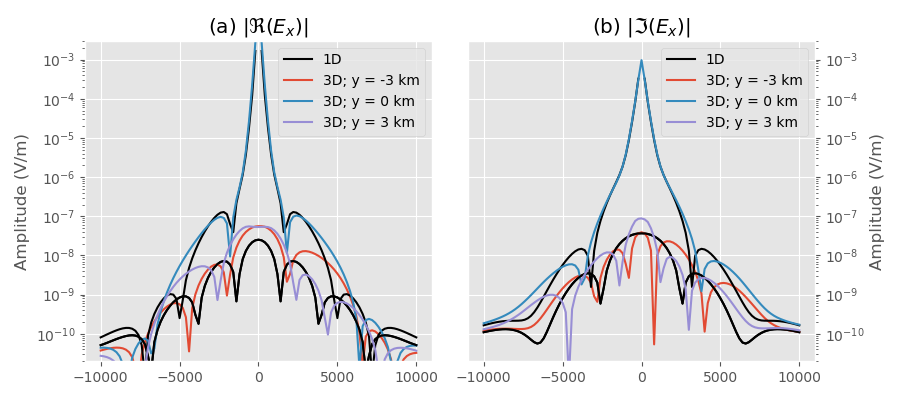

In [15]:
plt.figure(figsize=(9, 4))

# Real
ax1 = plt.subplot(121)
plt.title(r'(a) $|\Re(E_x)|$')

for i, y in enumerate(rec_y):
    plt.plot(rec_x, abs(getattr(epm_1d, f'line_{i+1}_re')), f'k-', label=f'1D' if i==0 else None)
    plt.plot(rec_x, abs(egd_tg[:, i].real), f'C{i}-', label=f'3D; y = {rec_y[i]/1e3:.0f} km')
    
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(122, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

for i, y in enumerate(rec_y):
    plt.plot(rec_x, abs(getattr(epm_1d, f'line_{i+1}_im')), f'k-', label=f'1D' if i==0 else None)
    plt.plot(rec_x, abs(egd_tg[:, i].imag), f'C{i}-', label=f'3D; y = {rec_y[i]/1e3:.0f} km')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

## Save data

In [16]:
### SAVE LAYERED BACKGROUND ###

# Save the three lines
survey.line_1_re.data = egd_bg[:, 0].real
survey.line_1_im.data = egd_bg[:, 0].imag
survey.line_2_re.data = egd_bg[:, 1].real
survey.line_2_im.data = egd_bg[:, 1].imag
survey.line_3_re.data = egd_bg[:, 0].real  # layered background, 2 is same as 1
survey.line_3_im.data = egd_bg[:, 0].imag

# Add info  ############################## TODO ###########################
survey.attrs['runtime'] = 'N/A'   # TODO
survey.attrs['cputime'] = 'N/A'   # TODO
survey.attrs['nthreads'] = 'N/A'  # TODO
survey.attrs['maxram'] = 'N/A'    # TODO
survey.attrs['ncell'] = 'N/A'     # TODO
survey.attrs['nedges'] = 'N/A'
survey.attrs['machine'] = "laptop with an i7-6600U CPU@2.6 GHz (x4) and 16 GB of memory, using Ubuntu 18.04"
survey.attrs['version'] = emg3d.__version__
survey.attrs['date'] = datetime.today().isoformat()

# Add other meta data: add whatever you think is important for your code
survey.attrs['meta'] = emg3d.Report([discretize, xr]).__repr__()

# Save it under <{model}_{code}.nc>
survey.to_netcdf(f"../results/layered_emg3d.nc", engine='h5netcdf')

### SAVE BLOCK MODEL ###

# Add info  ############################## TODO ###########################
survey.attrs['runtime'] = 'N/A'   # TODO
survey.attrs['cputime'] = 'N/A'   # TODO
survey.attrs['nthreads'] = 'N/A'  # TODO
survey.attrs['maxram'] = 'N/A'    # TODO
survey.attrs['ncell'] = 'N/A'     # TODO

# Save the three lines
survey.line_1_re.data = egd_tg[:, 0].real
survey.line_1_im.data = egd_tg[:, 0].imag
survey.line_2_re.data = egd_tg[:, 1].real
survey.line_2_im.data = egd_tg[:, 1].imag
survey.line_3_re.data = egd_tg[:, 0].real  # layered background, 2 is same as 1
survey.line_3_im.data = egd_tg[:, 0].imag

# Save it under <{model}_{code}.nc>
survey.to_netcdf(f"../results/block_emg3d.nc", engine='h5netcdf')

In [17]:
emg3d.Report([discretize, xr])

--------------------------------------------------------------------------------
  Date: Wed Mar 18 07:31:44 2020 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.7 GB
       Environment : Jupyter

  Python 3.7.6 (default, Jan  8 2020, 19:59:22)  [GCC 7.3.0]

        discretize : 0.4.11
            xarray : 0.15.0
             numpy : 1.18.1
             scipy : 1.4.1
             numba : 0.48.0
             emg3d : 0.9.4.dev4+ga8d8de2
           IPython : 7.12.0
        matplotlib : 3.1.3

  Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------